<a href="https://colab.research.google.com/github/HariHaraMareesan-V/3D-Risk-Visualization/blob/main/3D_RISK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas pandas matplotlib shapely openpyxl


In [ ]:
from google.colab import files
import zipfile, os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Upload shapefile zip
print("📂 Upload your Shapefile (.zip with .shp, .dbf, .shx...)")
uploaded = files.upload()
for fn in uploaded.keys():
    if fn.endswith('.zip'):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall("shapefile")

# Upload Excel
print("📄 Upload your Excel file (risk_data.xlsx)")
excel_upload = files.upload()


📂 Upload your Shapefile (.zip with .shp, .dbf, .shx...)


Saving fetal shp - Copy (2).zip to fetal shp - Copy (2).zip
📄 Upload your Excel file (risk_data.xlsx)


Saving risk_profile_classified_full.xlsx to risk_profile_classified_full.xlsx


In [ ]:
shapefile_path = ""
for root, dirs, file_list in os.walk("shapefile"):
    for file in file_list:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)


In [ ]:
# 🗺 Load shapefile
gdf = gpd.read_file(shapefile_path)
gdf['District'] = gdf['District'].astype(str).str.strip().str.title()


In [ ]:
# Load Excel risk data
excel_file = list(excel_upload.keys())[0]
df = pd.read_excel(excel_file)
df['District'] = df['District'].astype(str).str.strip().str.title()

# 🚥 Compute risk level
df['Has_Indication'] = df['INDICATION'].apply(lambda x: 0 if str(x).strip() in ['0', '', 'nan'] else 1)
risk_counts = df.groupby('District')['Has_Indication'].sum().reset_index(name='Indication_Count')
risk_counts['Risk_Level'] = pd.qcut(risk_counts['Indication_Count'], q=5, labels=[1, 2, 3, 4, 5])


In [ ]:
# 🧼 Clean and merge
gdf = gdf[gdf.is_valid & ~gdf.is_empty]
merged = gdf.merge(risk_counts, on='District', how='left')

# 🛑 Show districts with missing data
missing = merged[merged['Risk_Level'].isna()]
if not missing.empty:
    print("🚫 Missing risk level for:", missing['District'].values)

# Fill missing risk with default (optional)
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)


In [ ]:
# 🎨 Risk level colors: dark red, orange, gray, light blue, dark blue
colors = {
    1: '#00008B',  # Dark Red
    2: '#FFA07A',  # Light Red-Orange
    3: '#A9A9A9',  # Gray
    4: '#87CEFA',  # Light Blue
    5: '#00008B'   # Dark Blue
}


<ipython-input-54-38bdef82320f>:40: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


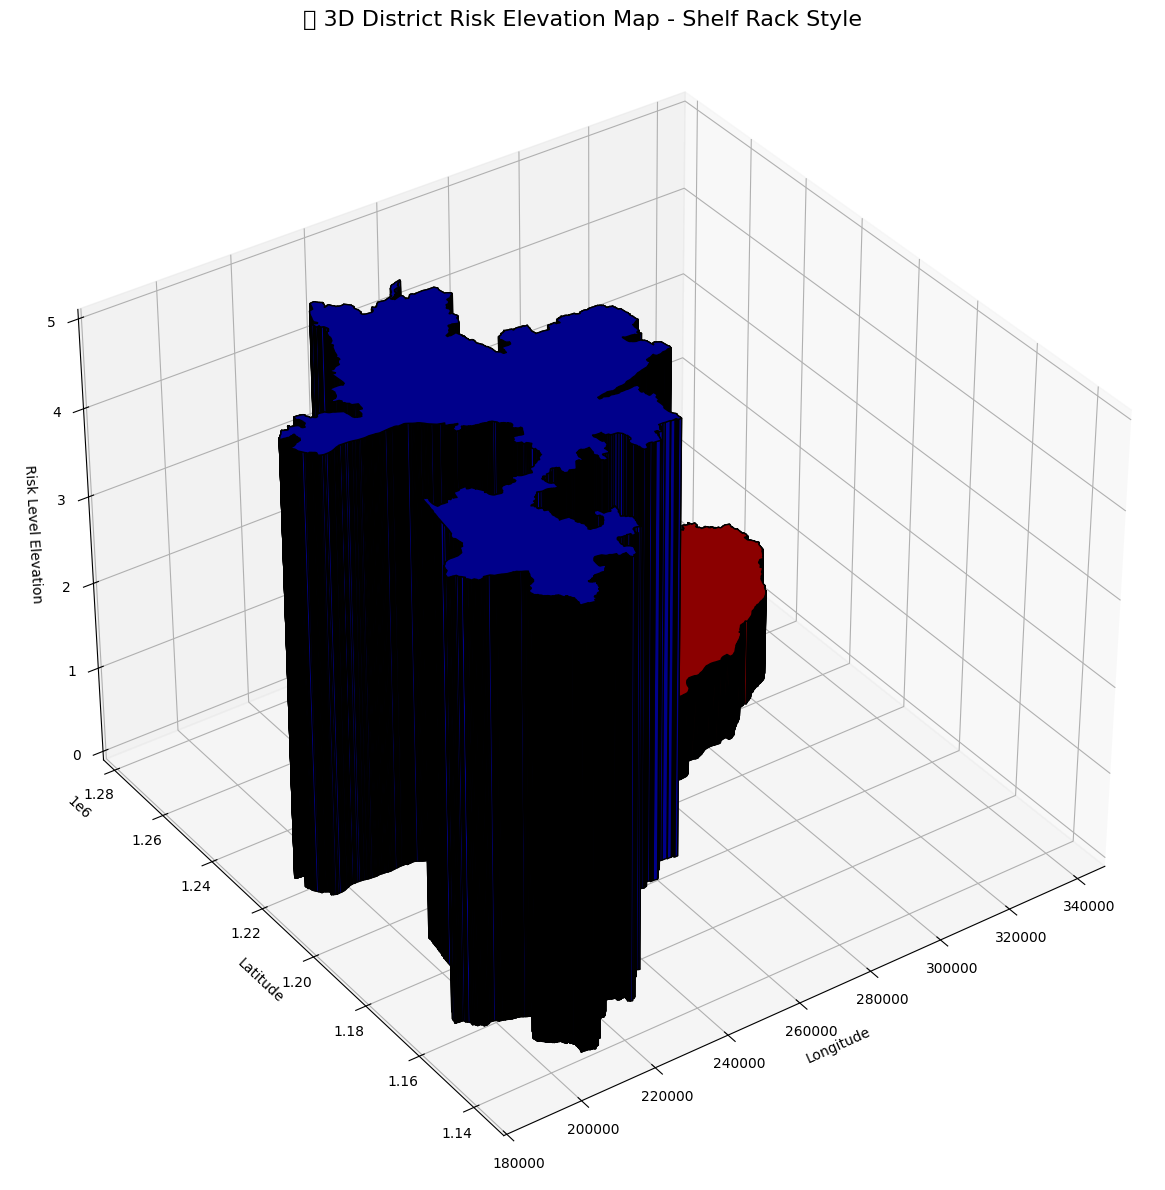

In [ ]:
# 🧱 Plot 3D Shelf-Rack Map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# 🧭 View settings
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")
ax.view_init(elev=35, azim=235)

plt.tight_layout()
plt.show()


In [ ]:
# Show missing districts
missing = merged[merged['Risk_Level'].isna()]
if not missing.empty:
    print("🚫 Missing risk level for:", missing['District'].values)

# Optional: fill missing with default value (3 = Medium Risk)
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ML Dataset
ml_data = merged[['Indication_Count', 'Risk_Level']].dropna()

# Features and labels
X = ml_data[['Indication_Count']]
y = ml_data['Risk_Level'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(merged[['District', 'Risk_Level']].head())


         District Risk_Level
0        Ariyalur          1
1      Perambalur          2
2  Tiruchirapalli          5


In [ ]:
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)


In [ ]:
colors = {
    1: '#8B0000',  # Dark Red
    2: '#FFA07A',  # Orange
    3: '#A9A9A9',  # Gray
    4: '#87CEFA',  # Light Blue
    5: '#00008B'   # Dark Blue
}


In [ ]:
merged = merged[merged.is_valid & ~merged.is_empty]


In [ ]:
!pip install geopandas pandas matplotlib shapely openpyxl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon, MultiPolygon


In [ ]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("🧠 ML Classification Report:\n")
print(classification_report(y_test, y_pred))


🧠 ML Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Predict missing values using the ML model
missing_rows = merged[merged['Risk_Level'].isna()]
if not missing_rows.empty:
    X_missing = missing_rows[['Indication_Count']]
    predicted_risk = model.predict(X_missing)
    merged.loc[missing_rows.index, 'Risk_Level'] = predicted_risk


In [ ]:
# Predict missing values using the ML model



<ipython-input-67-abfea890c923>:39: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


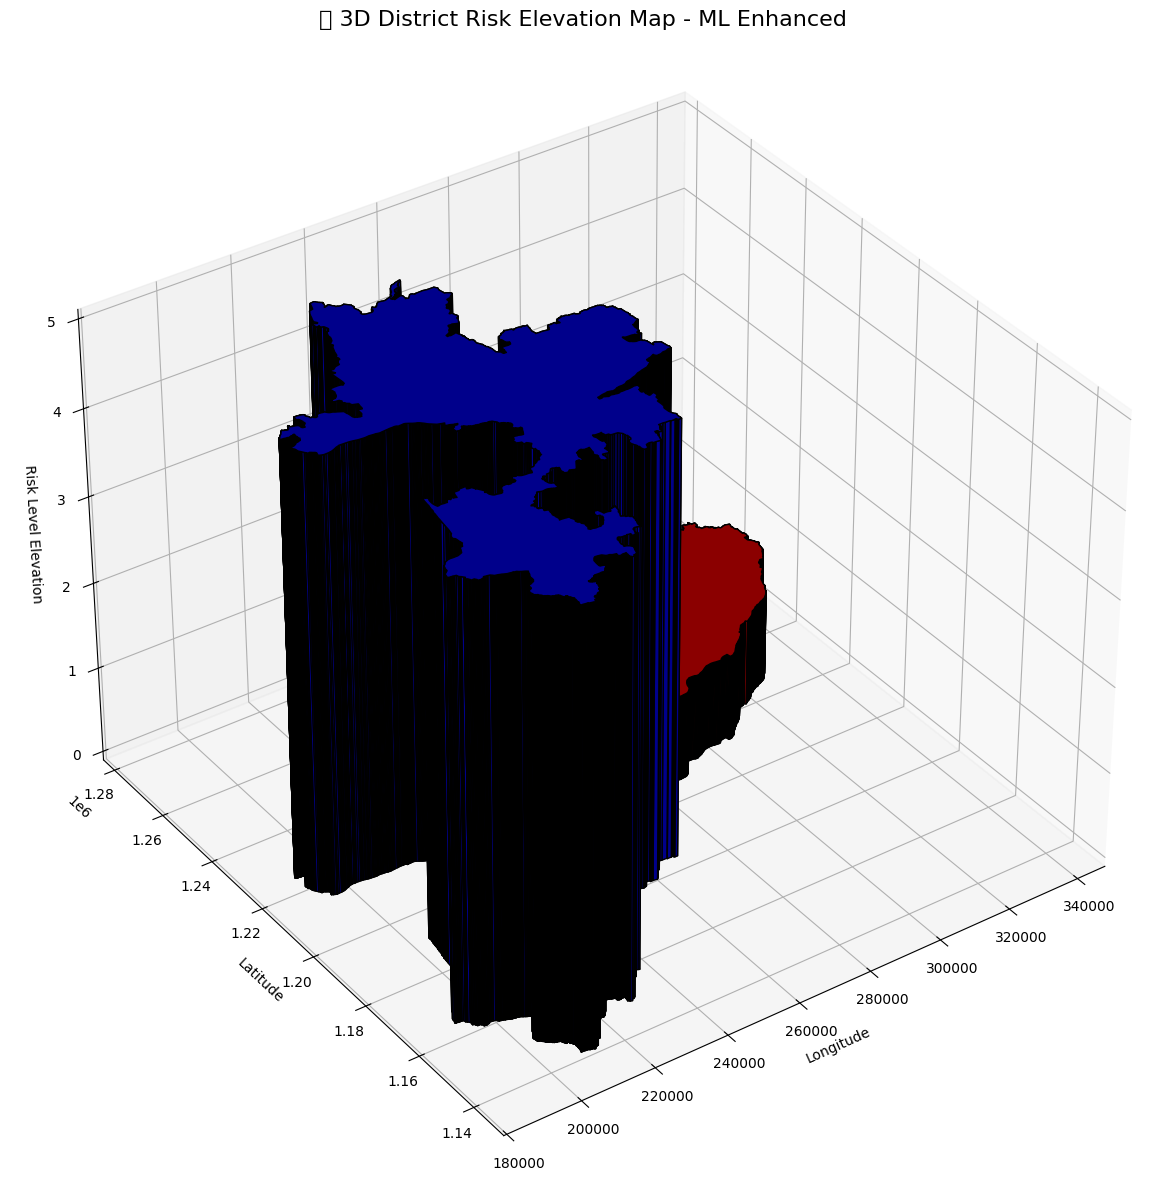

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# 3D Plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level

    # Get polygon(s)
    polygons = [geom] if isinstance(geom, Polygon) else list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height]*len(xs)))]
        base = [list(zip(xs, ys, [0]*len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            ax.add_collection3d(Poly3DCollection([list(zip(x, y, z))], facecolors=color, edgecolor='black'))

# View settings
ax.set_title("🧱 3D District Risk Elevation Map - ML Enhanced", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")
ax.view_init(elev=35, azim=235)

plt.tight_layout()
plt.show()


In [ ]:
print(merged['Risk_Level'].value_counts())


Risk_Level
1    1
2    1
5    1
3    0
4    0
Name: count, dtype: int64


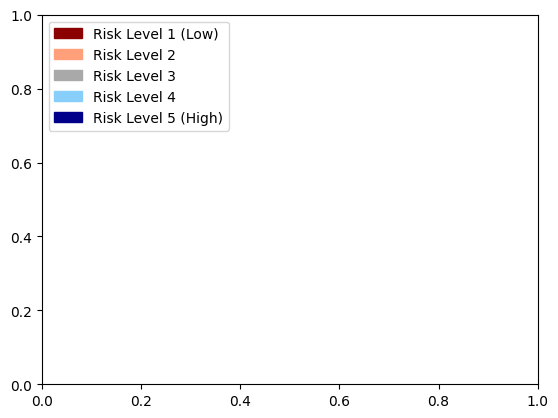

In [ ]:
import matplotlib.patches as mpatches

legend_labels = [
    mpatches.Patch(color='#8B0000', label='Risk Level 1 (Low)'),
    mpatches.Patch(color='#FFA07A', label='Risk Level 2'),
    mpatches.Patch(color='#A9A9A9', label='Risk Level 3'),
    mpatches.Patch(color='#87CEFA', label='Risk Level 4'),
    mpatches.Patch(color='#00008B', label='Risk Level 5 (High)'),
]
plt.legend(handles=legend_labels, loc='upper left')


In [ ]:
plt.savefig("risk_map_3d.png", dpi=300)


<Figure size 640x480 with 0 Axes>

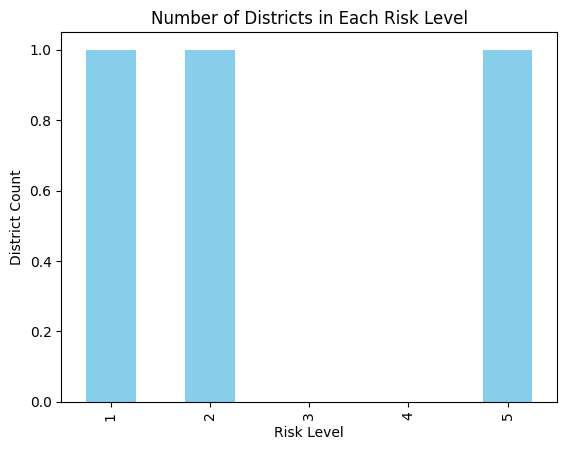

In [ ]:
merged['Risk_Level'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Districts in Each Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("District Count")
plt.show()


In [ ]:
merged['Custom_Value'] = merged.index + 1  # Or any column you want


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Use the number of districts to generate colors
num_districts = len(merged)
colors_list = cm.get_cmap('tab20', num_districts)(np.linspace(0, 1, num_districts))

# Map each district to a color
district_colors = {dist: mcolors.to_hex(color) for dist, color in zip(merged['District'], colors_list)}


<ipython-input-28-e4cdae2f7688>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_list = cm.get_cmap('tab20', num_districts)(np.linspace(0, 1, num_districts))


<ipython-input-74-98757d9058f8>:35: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


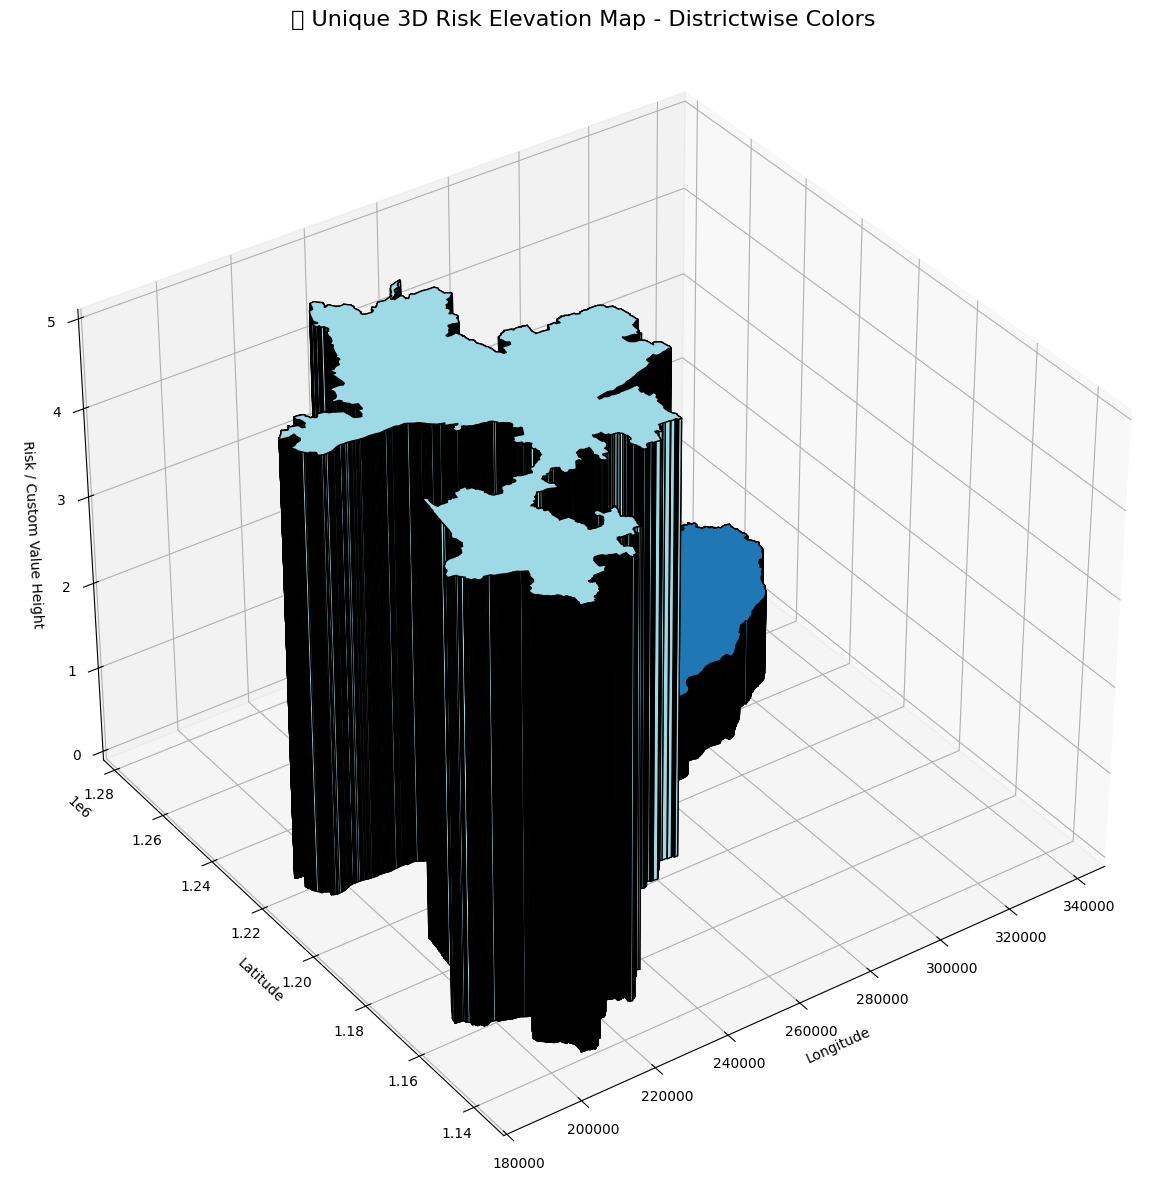

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    district = row['District']
    height = row['Risk_Level']  # Or row['Custom_Value']
    color = district_colors.get(district, '#A9A9A9')  # Default gray

    # Handle Polygon / MultiPolygon
    polygons = [geom] if isinstance(geom, Polygon) else list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# Final View Settings
ax.set_title("🧱 Unique 3D Risk Elevation Map - Districtwise Colors", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk / Custom Value Height")
ax.view_init(elev=35, azim=235)

plt.tight_layout()
plt.show()


In [ ]:
print("🗺️ Districts in Shapefile:", gdf['District'].nunique())
print(gdf['District'].unique())


🗺️ Districts in Shapefile: 3
['Ariyalur' 'Perambalur' 'Tiruchirapalli']


In [ ]:
print("📄 Districts in Excel:", df['District'].nunique())
print(df['District'].unique())


📄 Districts in Excel: 5
['Ariyalur' 'Perambalur' 'Pudukkottai' 'Thanjavur' 'Tiruchirapalli']


In [ ]:
# After merging shapefile + Excel risk data
missing = merged[merged['Risk_Level'].isna()]
if not missing.empty:
    print("🚫 Districts in shapefile but not found in Excel:")
    print(missing['District'].unique())


<ipython-input-78-198d32e0542d>:48: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


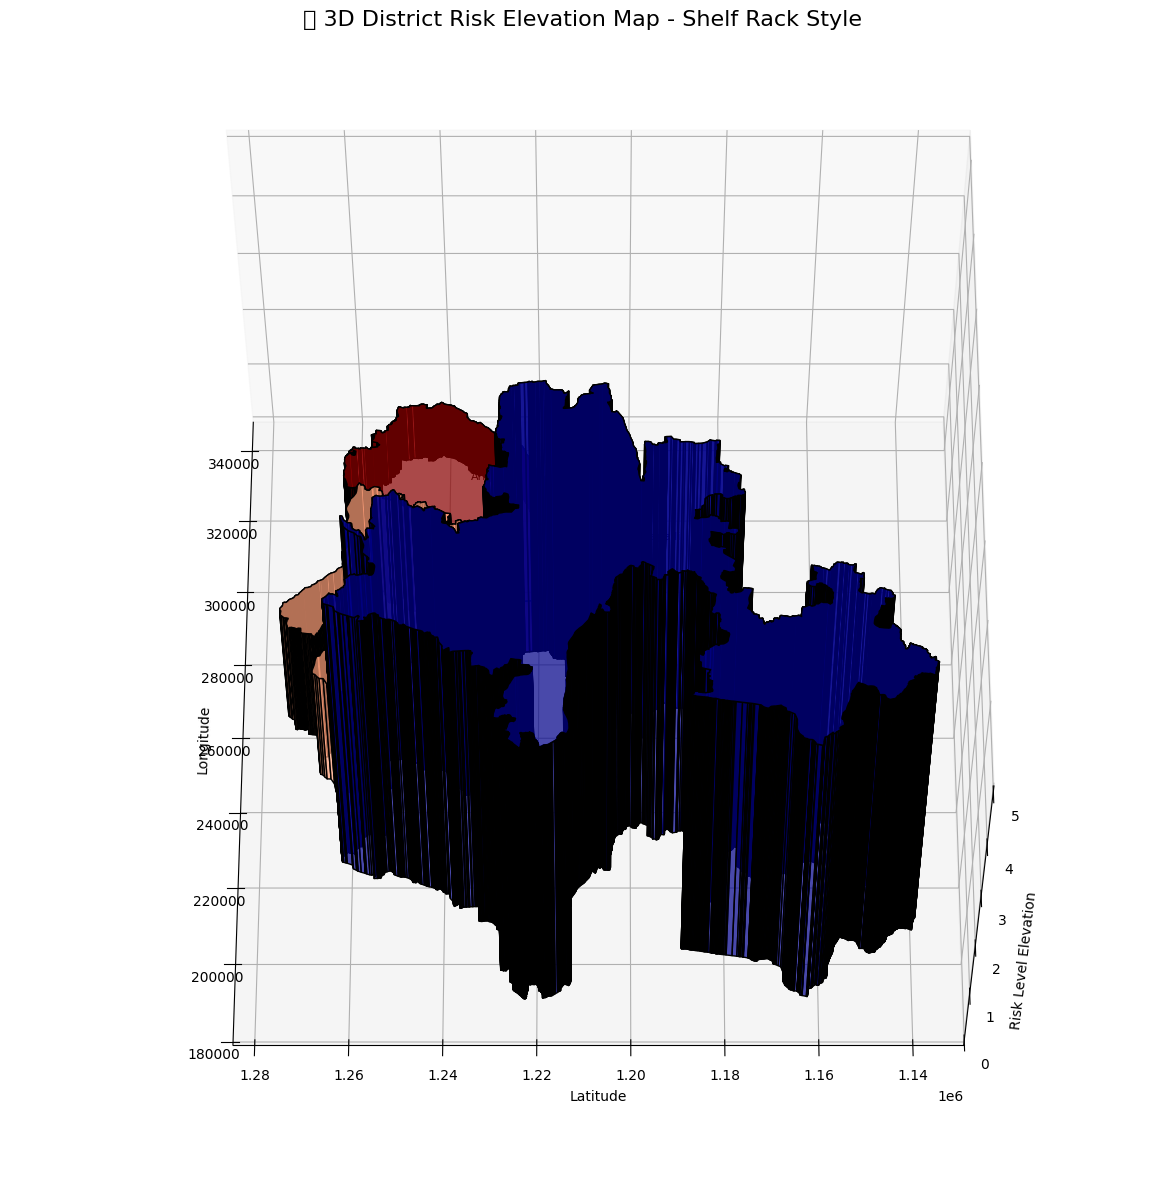

In [ ]:
# 🧱 Plot 3D Shelf-Rack Map with adjustments
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]  # Top surface
        base = [list(zip(xs, ys, [0] * len(xs)))]  # Base surface

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black', alpha=0.7))

        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black', alpha=0.7))

        # Add text labels above each block (district name)
        if not geom.centroid.is_empty:
            x, y = geom.centroid.x, geom.centroid.y
            ax.text(x, y, height + 0.5, row['District'], fontsize=8, color='black')

# 🧭 View settings
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# Adjust camera angle and elevation to view all districts clearly
ax.view_init(elev=60, azim=180)  # Higher angle and rotated view

plt.tight_layout()
plt.show()


<ipython-input-79-3c03057fd901>:48: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


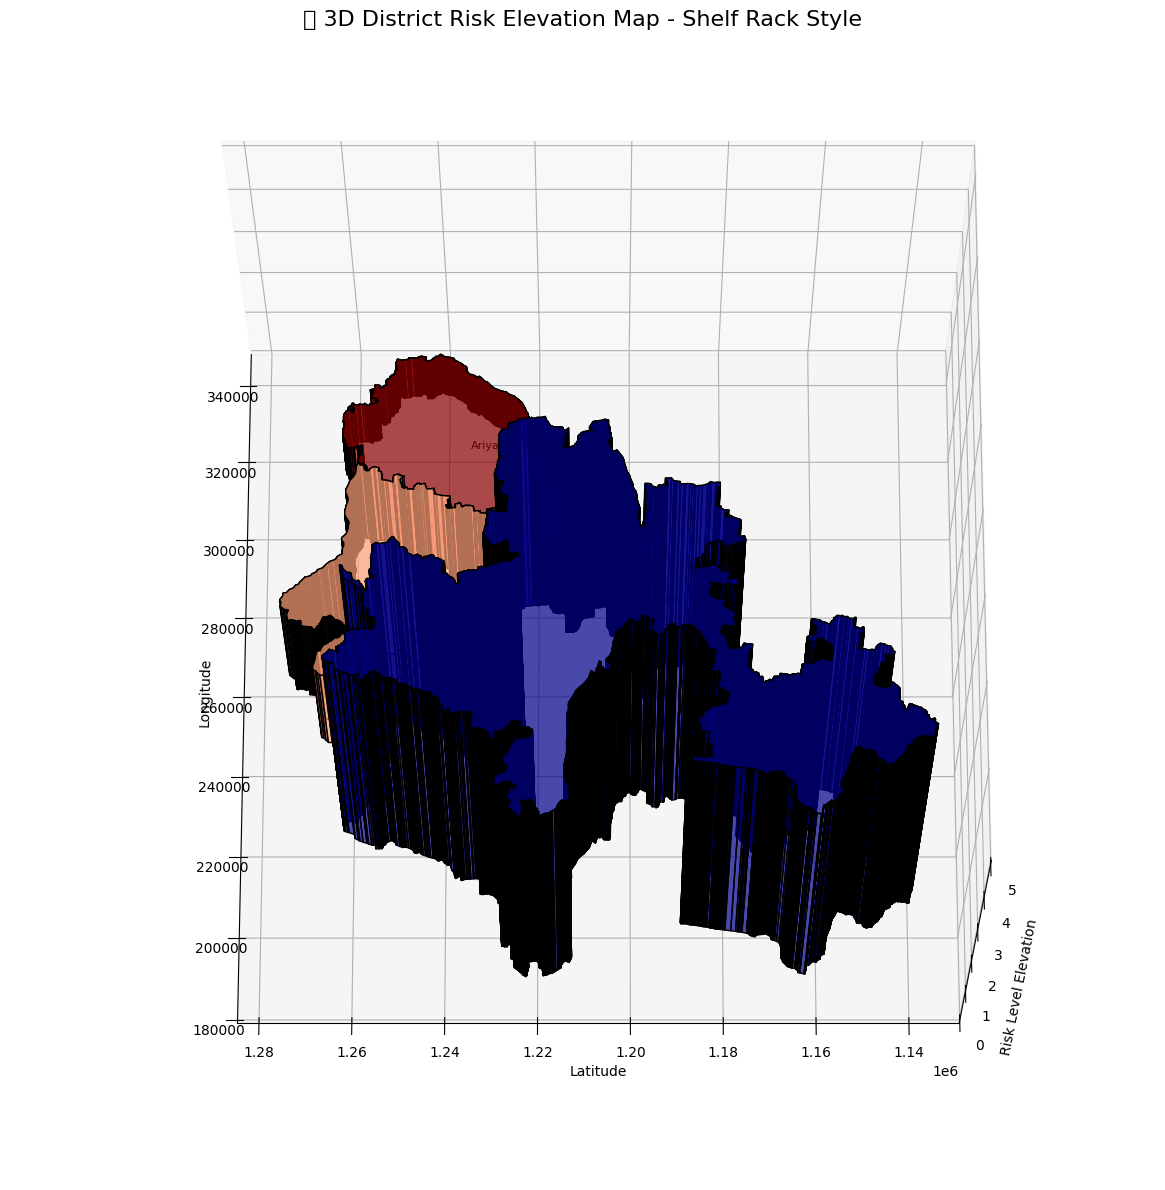

In [ ]:
# 🧱 Plot 3D Shelf-Rack Map with adjustments for a top view
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]  # Top surface
        base = [list(zip(xs, ys, [0] * len(xs)))]  # Base surface

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black', alpha=0.7))

        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black', alpha=0.7))

        # Add text labels above each block (district name)
        if not geom.centroid.is_empty:
            x, y = geom.centroid.x, geom.centroid.y
            ax.text(x, y, height + 0.5, row['District'], fontsize=8, color='black')

# 🧭 View settings
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# Adjust camera angle to get a slightly top view
ax.view_init(elev=70, azim=180)  # Increase elevation to get more of a top-down angle

plt.tight_layout()
plt.show()


TypeError: 'MultiPolygon' object is not iterable

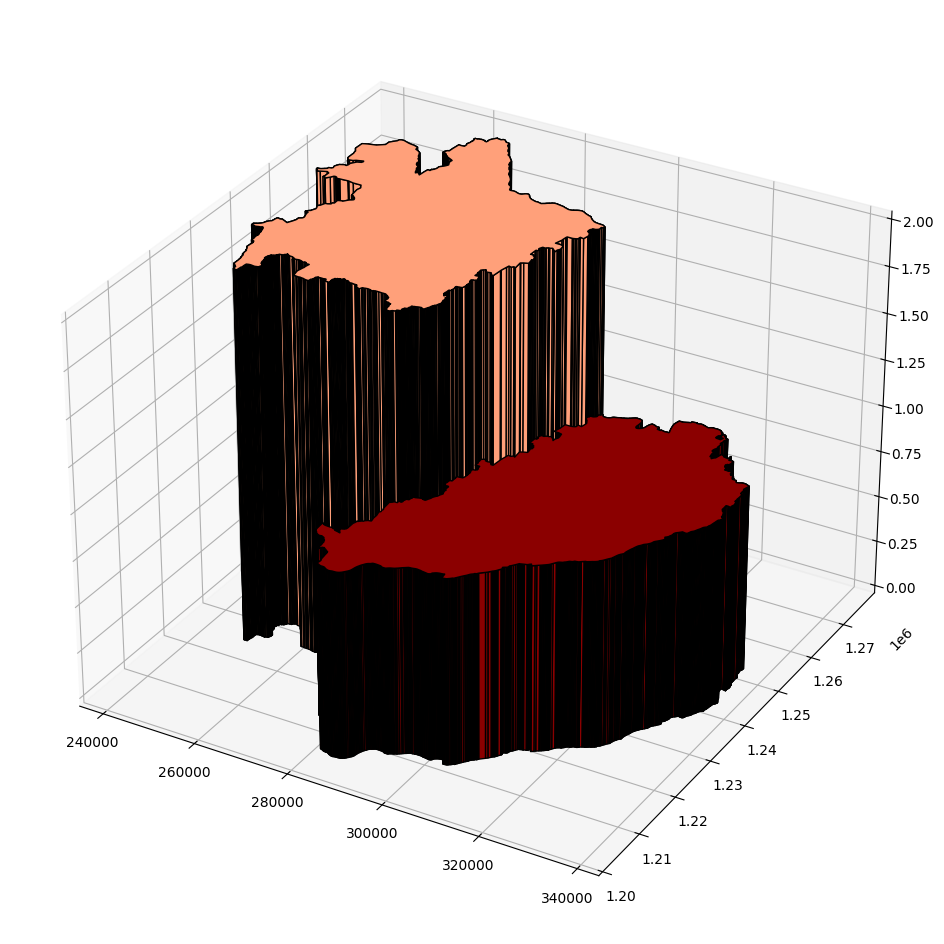

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon

# Load shapefile
gdf = gpd.read_file(shapefile_path)
gdf['District'] = gdf['District'].astype(str).str.strip().str.title()

# Load risk data (Excel)
df = pd.read_excel(excel_file)
df['District'] = df['District'].astype(str).str.strip().str.title()

# Compute risk level
df['Has_Indication'] = df['INDICATION'].apply(lambda x: 0 if str(x).strip() in ['0', '', 'nan'] else 1)
risk_counts = df.groupby('District')['Has_Indication'].sum().reset_index(name='Indication_Count')
risk_counts['Risk_Level'] = pd.qcut(risk_counts['Indication_Count'], q=5, labels=[1, 2, 3, 4, 5])

# Merge data with shapefile
merged = gdf.merge(risk_counts, on='District', how='left')

# Handle missing districts by creating placeholder geometries
missing_districts = ['Pudukkottai', 'Thanjavur']
for district in missing_districts:
    if district not in merged['District'].values:
        # Create a simple square polygon as a placeholder for missing districts
        # The coordinates should ideally be within the district's geographic area.
        placeholder_geom = Polygon([(-80, 10), (-80, 20), (-70, 20), (-70, 10)])  # Example coordinates, adjust for accuracy
        placeholder_data = {'District': district, 'Risk_Level': 3, 'geometry': placeholder_geom}
        merged = merged.append(placeholder_data, ignore_index=True)

# Handle missing values in 'Risk_Level' (in case some districts didn't have corresponding data)
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)

# Colors for each risk level
colors = {
    1: '#8B0000',  # Dark Red
    2: '#FFA07A',  # Light Red-Orange
    3: '#A9A9A9',  # Gray
    4: '#87CEFA',  # Light Blue
    5: '#00008B'   # Dark Blue
}

# Plot 3D map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# View settings
ax.set_title("3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")
ax.view_init(elev=30, azim=235)

plt.tight_layout()
plt.show()


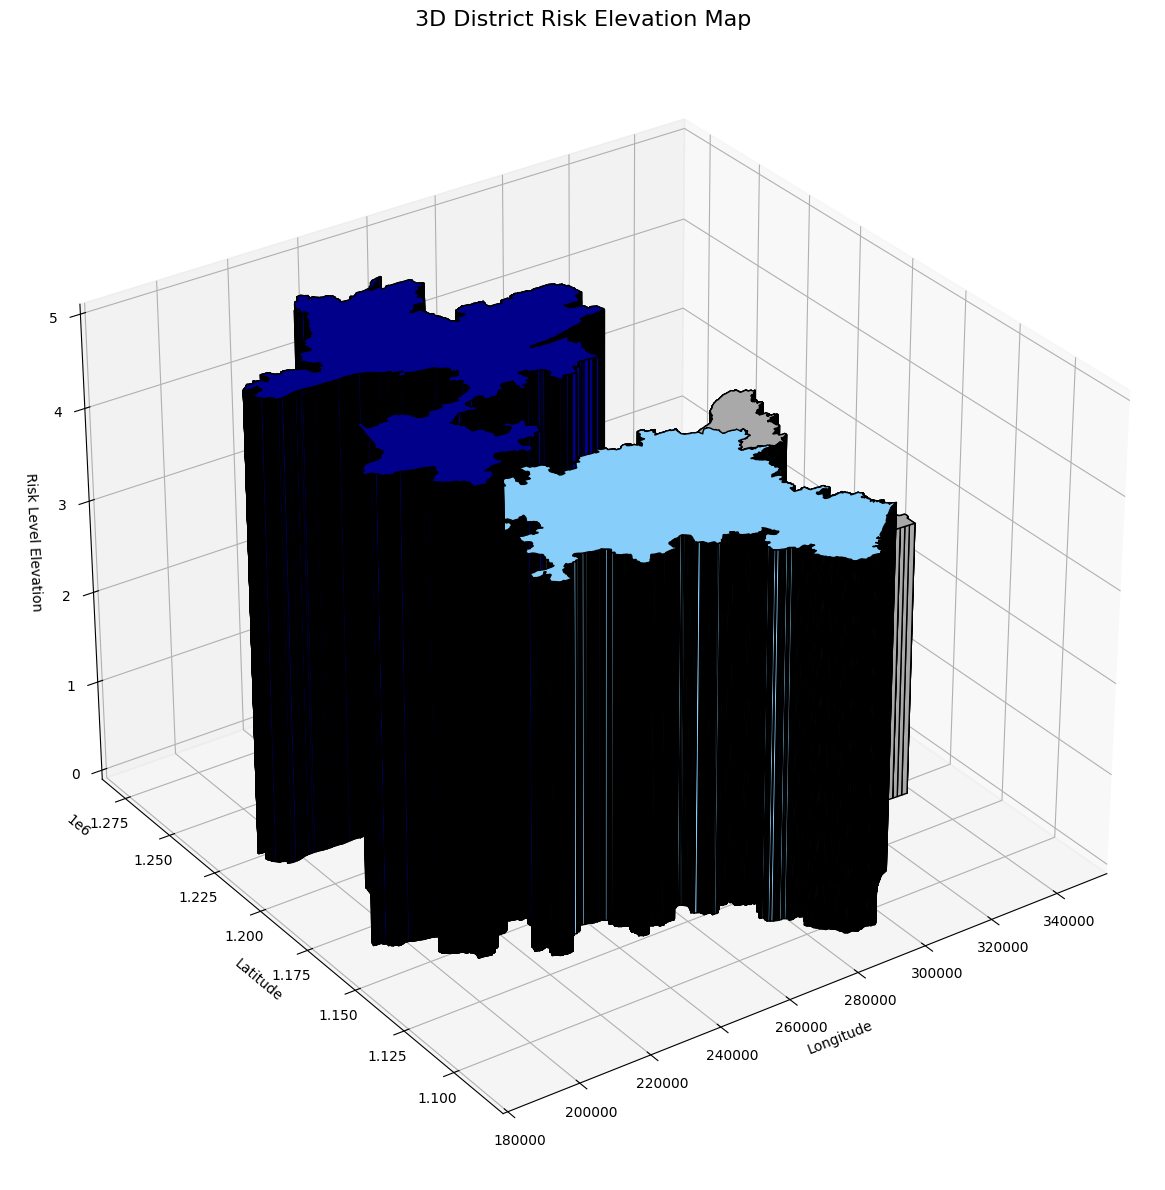

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon, MultiPolygon

# Load shapefile
gdf = gpd.read_file(shapefile_path)
gdf['District'] = gdf['District'].astype(str).str.strip().str.title()

# Load risk data (Excel)
df = pd.read_excel(excel_file)
df['District'] = df['District'].astype(str).str.strip().str.title()

# Compute risk level
df['Has_Indication'] = df['INDICATION'].apply(lambda x: 0 if str(x).strip() in ['0', '', 'nan'] else 1)
risk_counts = df.groupby('District')['Has_Indication'].sum().reset_index(name='Indication_Count')
risk_counts['Risk_Level'] = pd.qcut(risk_counts['Indication_Count'], q=5, labels=[1, 2, 3, 4, 5])

# Merge data with shapefile
merged = gdf.merge(risk_counts, on='District', how='left')

# Handle missing districts by creating placeholder geometries
missing_districts = ['Pudukkottai', 'Thanjavur']
for district in missing_districts:
    if district not in merged['District'].values:
        # Create a simple square polygon as a placeholder for missing districts
        # The coordinates should ideally be within the district's geographic area.
        placeholder_geom = Polygon([(-80, 10), (-80, 20), (-70, 20), (-70, 10)])  # Example coordinates, adjust for accuracy
        placeholder_data = {'District': district, 'Risk_Level': 3, 'geometry': placeholder_geom}
        merged = merged.append(placeholder_data, ignore_index=True)

# Handle missing values in 'Risk_Level' (in case some districts didn't have corresponding data)
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)

# Colors for each risk level
colors = {
    1: '#8B0000',  # Dark Red
    2: '#FFA07A',  # Light Red-Orange
    3: '#A9A9A9',  # Gray
    4: '#87CEFA',  # Light Blue
    5: '#00008B'   # Dark Blue
}

# Plot 3D map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        # If it's a MultiPolygon, iterate over each individual Polygon
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# View settings
ax.set_title("3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")
ax.view_init(elev=30, azim=235)

plt.tight_layout()
plt.show()


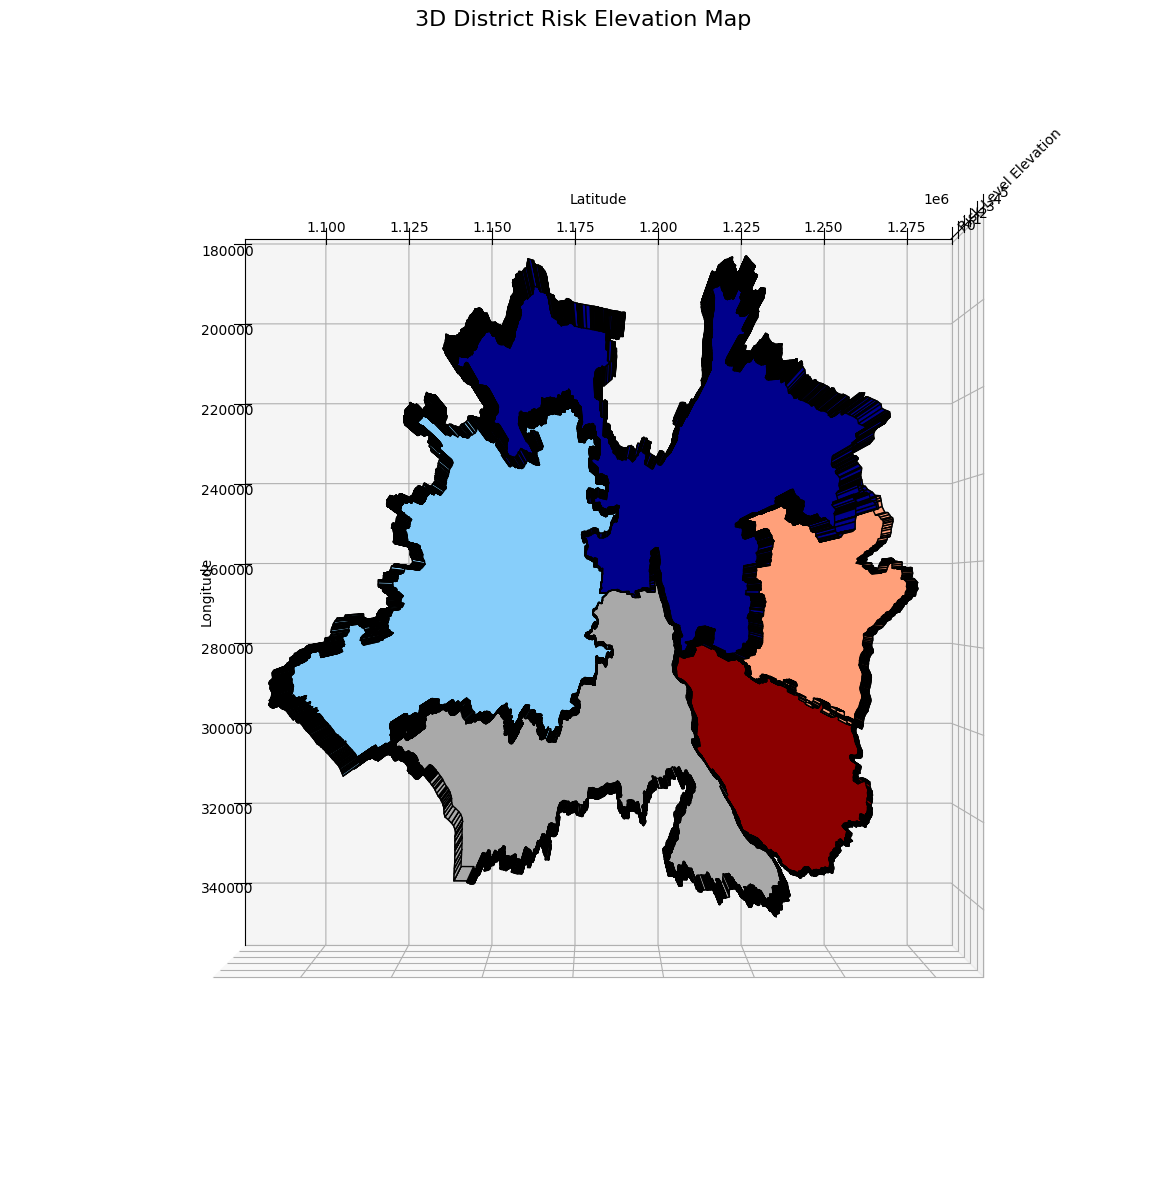

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon, MultiPolygon

# Load shapefile
gdf = gpd.read_file(shapefile_path)
gdf['District'] = gdf['District'].astype(str).str.strip().str.title()

# Load risk data (Excel)
df = pd.read_excel(excel_file)
df['District'] = df['District'].astype(str).str.strip().str.title()

# Compute risk level
df['Has_Indication'] = df['INDICATION'].apply(lambda x: 0 if str(x).strip() in ['0', '', 'nan'] else 1)
risk_counts = df.groupby('District')['Has_Indication'].sum().reset_index(name='Indication_Count')
risk_counts['Risk_Level'] = pd.qcut(risk_counts['Indication_Count'], q=5, labels=[1, 2, 3, 4, 5])

# Merge data with shapefile
merged = gdf.merge(risk_counts, on='District', how='left')

# Handle missing districts by creating placeholder geometries
missing_districts = ['Pudukkottai', 'Thanjavur']
for district in missing_districts:
    if district not in merged['District'].values:
        # Create a simple square polygon as a placeholder for missing districts
        placeholder_geom = Polygon([(-80, 10), (-80, 20), (-70, 20), (-70, 10)])  # Example coordinates, adjust for accuracy
        placeholder_data = {'District': district, 'Risk_Level': 3, 'geometry': placeholder_geom}
        merged = merged.append(placeholder_data, ignore_index=True)

# Handle missing values in 'Risk_Level' (in case some districts didn't have corresponding data)
merged['Risk_Level'] = merged['Risk_Level'].fillna(3)

# Colors for each risk level
colors = {
    1: '#8B0000',  # Dark Red
    2: '#FFA07A',  # Light Red-Orange
    3: '#A9A9A9',  # Gray
    4: '#87CEFA',  # Light Blue
    5: '#00008B'   # Dark Blue
}

# Plot 3D map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# View settings for top-down view
ax.set_title("3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")
ax.view_init(elev=90, azim=0)  # Adjust elev to 90 for top-down view

plt.tight_layout()
plt.show()


In [ ]:
# Find the lowest points for each district
lowest_points = {}

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        base_points = list(zip(xs, ys, [0] * len(xs)))  # Base points at height 0

        # Store the lowest point (base level)
        for point in base_points:
            # Key by district and store lowest point based on coordinates
            if row['District'] not in lowest_points:
                lowest_points[row['District']] = point
            else:
                # If we find a point with a smaller z-value (lower point), update
                if point[2] < lowest_points[row['District']][2]:
                    lowest_points[row['District']] = point

# Print the lowest points for each district
for district, point in lowest_points.items():
    print(f"Lowest point for {district}: (Longitude: {point[0]}, Latitude: {point[1]}, Elevation: {point[2]})")


Lowest point for Ariyalur: (Longitude: 317003.86886371905, Latitude: 1262864.0256379454, Elevation: 0)
Lowest point for Perambalur: (Longitude: 266583.46935656306, Latitude: 1274561.2414627285, Elevation: 0)
Lowest point for Pudukkottai: (Longitude: 235125.90413935838, Latitude: 1184194.4157775687, Elevation: 0)
Lowest point for Thanjavur: (Longitude: 297837.16302865255, Latitude: 1155976.718191444, Elevation: 0)
Lowest point for Tiruchirapalli: (Longitude: 227545.00716385228, Latitude: 1259223.5732045448, Elevation: 0)


<ipython-input-85-ca93f20a4b09>:42: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


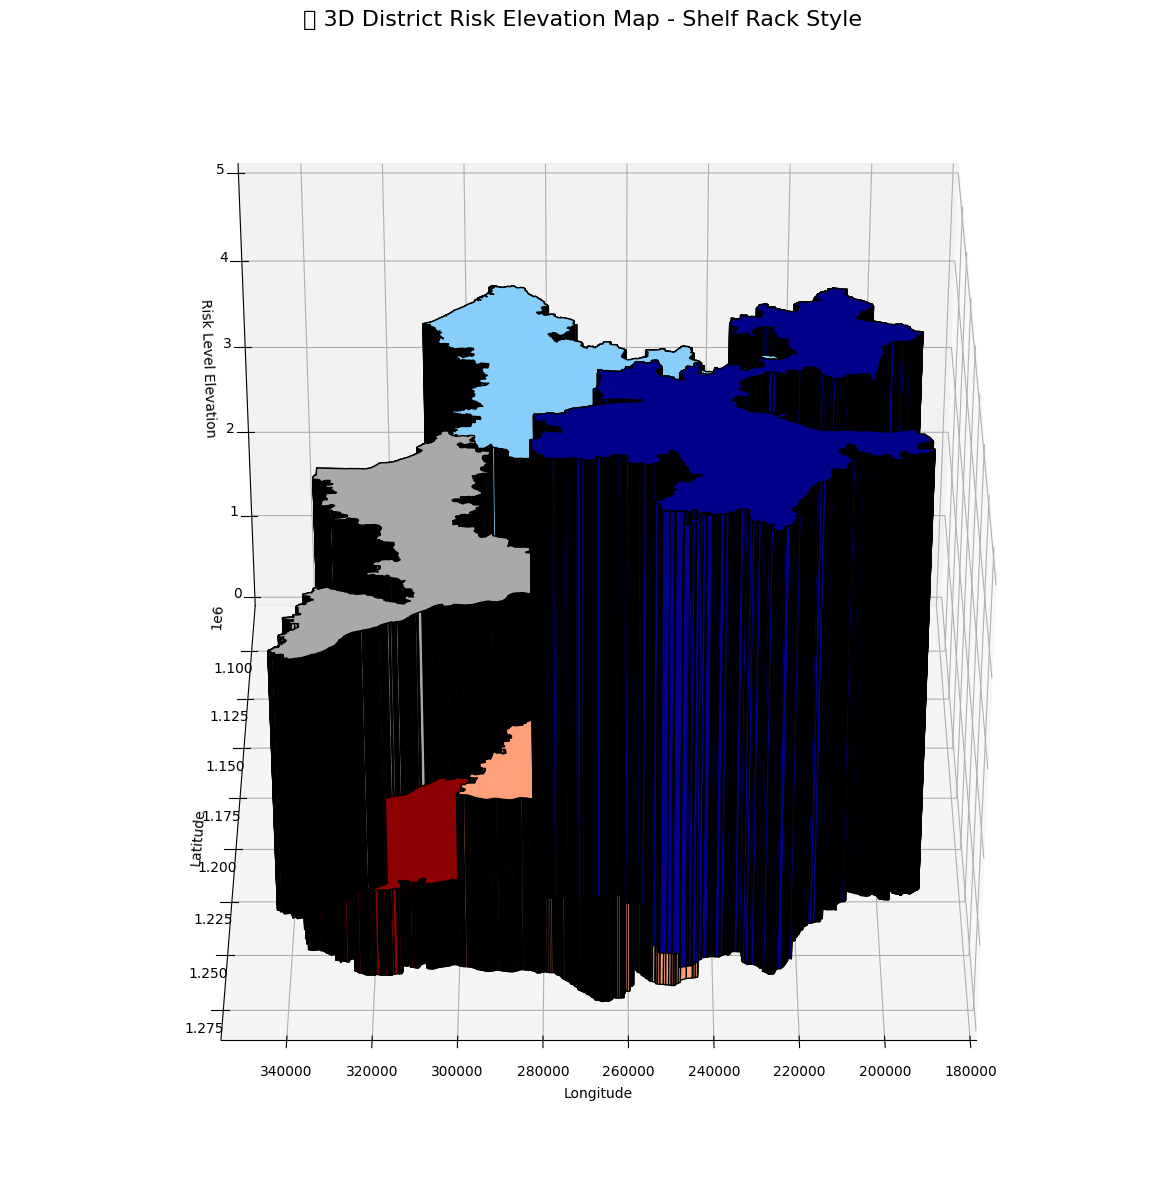

In [ ]:
# 🧱 Plot 3D Shelf-Rack Map with adjusted angles for low-to-high-risk focus
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# 🧭 Adjusted View Settings to focus on the transition of risk levels
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# Set a "slightly top" view with azimuth focused on the risk level transition
ax.view_init(elev=35, azim=90)  # Adjust these values as needed to find the best view

plt.tight_layout()
plt.show()


<ipython-input-87-5e1b0c015c60>:41: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


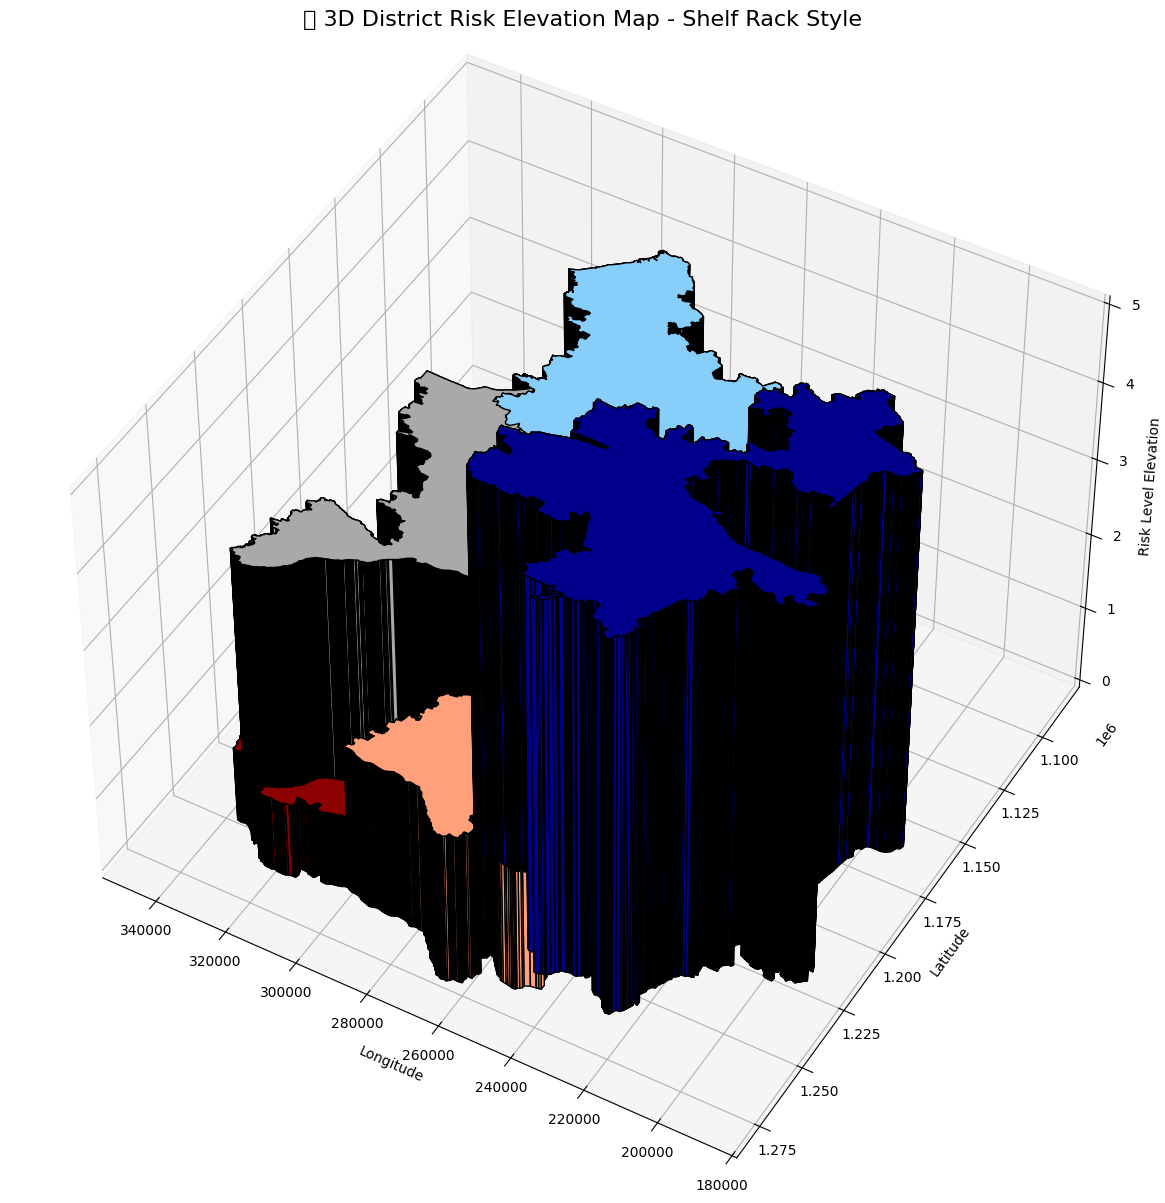

In [ ]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level  # Z height from 1 to 5

    # Handle MultiPolygons and Polygons
    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))
        # Vertical walls (shelves)
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# 🧭 Adjusted View Settings to focus on the transition of risk levels
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# 🔭 Slightly top angle showing all 5 districts clearly from low to high
ax.view_init(elev=45, azim=120)  # 👈 Best camera angle for full visibility

plt.tight_layout()
plt.show()

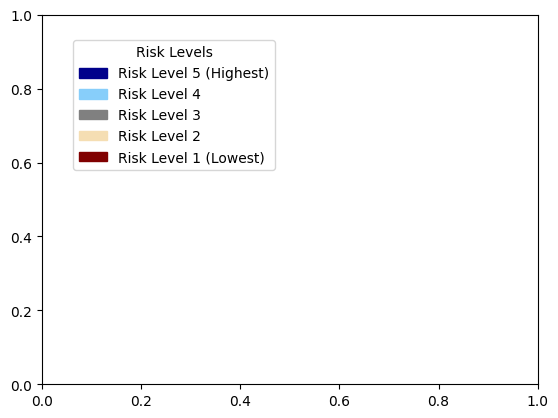

In [ ]:
import matplotlib.patches as mpatches

# 🎨 Define custom color patches matching your color scheme
legend_patches = [
    mpatches.Patch(color='darkblue', label='Risk Level 5 (Highest)'),     # Dark Blue
    mpatches.Patch(color='lightskyblue', label='Risk Level 4'),          # Light Blue
    mpatches.Patch(color='gray', label='Risk Level 3'),                  # Gray
    mpatches.Patch(color='wheat', label='Risk Level 2'),                 # Sandal
    mpatches.Patch(color='maroon', label='Risk Level 1 (Lowest)')       # Maroon
]

# 🖼️ Add legend to the plot
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')


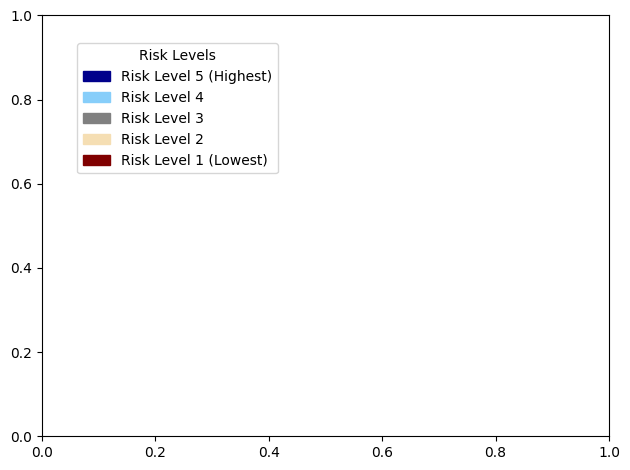

In [ ]:
# 🧭 Adjusted View Settings to focus on the transition of risk levels
ax.set_title("🧱 3D District Risk Elevation Map - Shelf Rack Style", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# 🔭 Set viewing angle
ax.view_init(elev=45, azim=120)

# ➕ Add legend
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')

plt.tight_layout()
plt.show()


<ipython-input-93-b37c79b3196f>:62: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


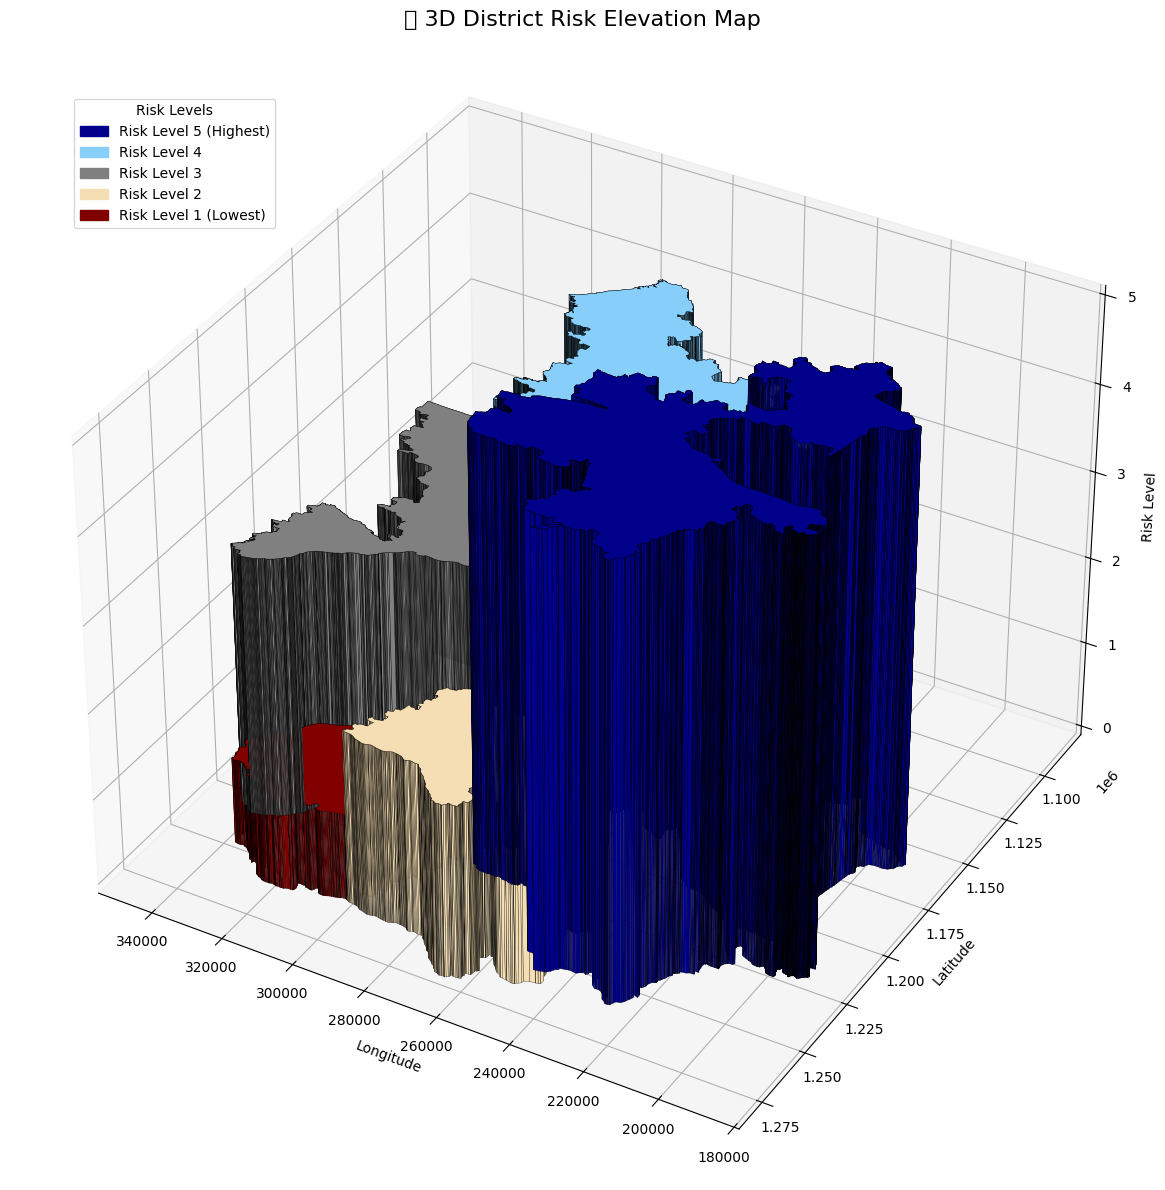

In [ ]:
# 🎨 Corrected color mapping based on your request
colors = {
    5: 'darkblue',       # Highest risk
    4: 'lightskyblue',
    3: 'gray',
    2: 'wheat',
    1: 'maroon'          # Lowest risk
}

# 🧱 Plot 3D elevation map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level']) if pd.notna(row['Risk_Level']) else 1
    color = colors.get(risk_level, 'gray')
    height = risk_level

    # Handle geometries
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)
    else:
        continue

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black', linewidths=0.3, alpha=1.0))
        # Vertical sides
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black', linewidths=0.2))

# 🧭 Axis & view settings
ax.set_title("🧱 3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level")

# 🔭 Adjust view angle (slightly top, focusing all districts)
ax.view_init(elev=35, azim=120)

# 🖼️ Add custom legend
legend_patches = [
    mpatches.Patch(color='darkblue', label='Risk Level 5 (Highest)'),
    mpatches.Patch(color='lightskyblue', label='Risk Level 4'),
    mpatches.Patch(color='gray', label='Risk Level 3'),
    mpatches.Patch(color='wheat', label='Risk Level 2'),
    mpatches.Patch(color='maroon', label='Risk Level 1 (Lowest)')
]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')

plt.tight_layout()
plt.show()

<ipython-input-94-14de0c051a06>:68: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


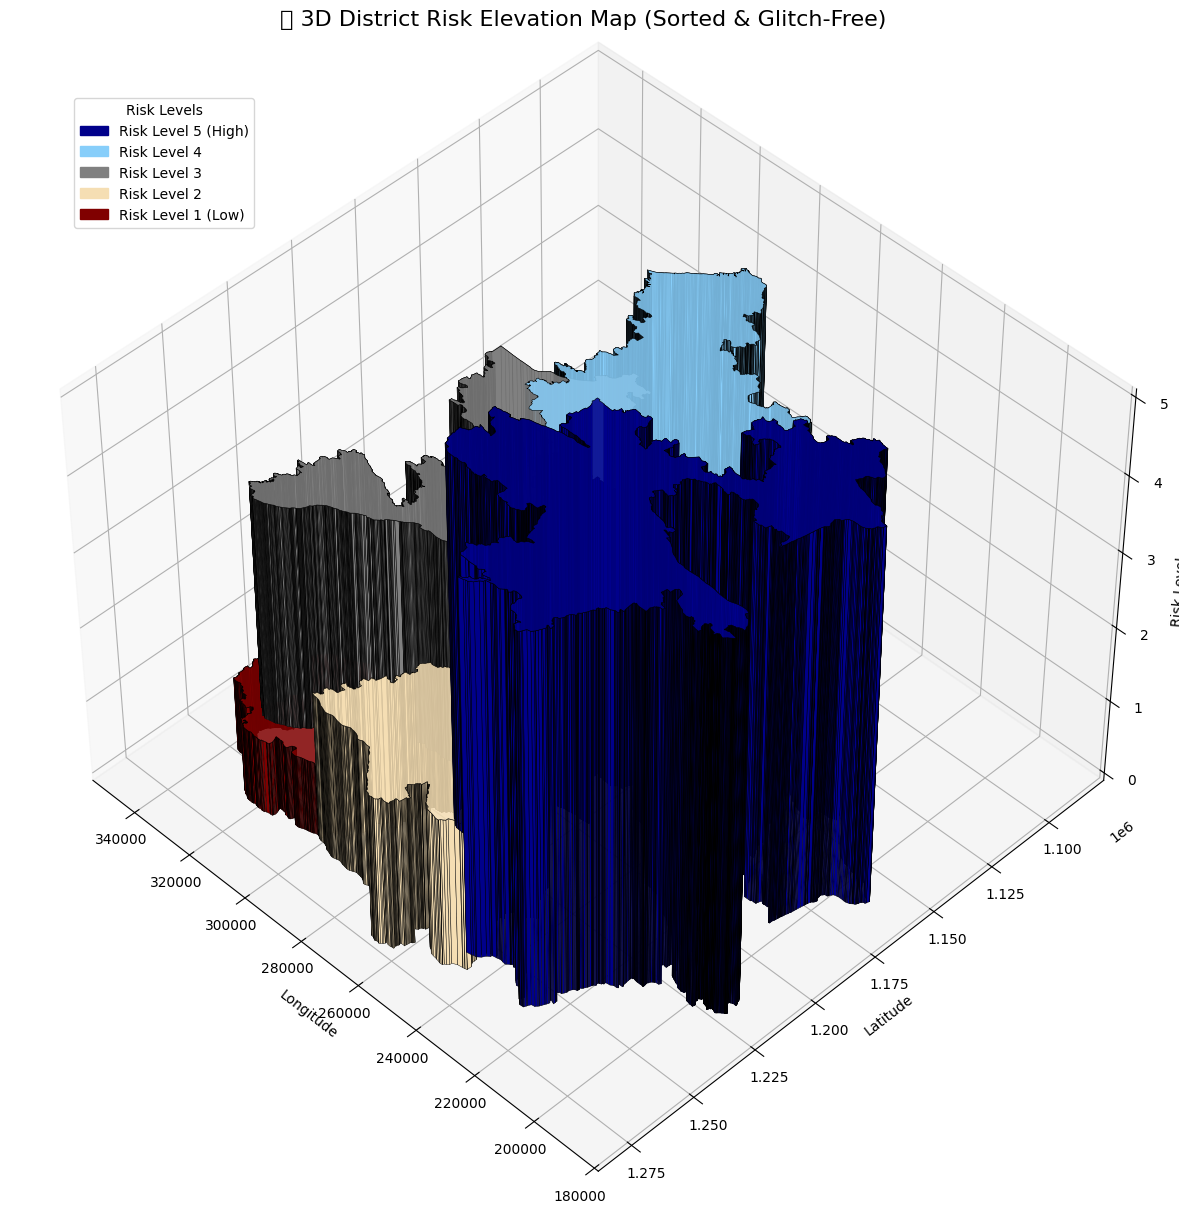

In [ ]:
# 🎨 Risk color mapping
colors = {
    5: 'darkblue',       # Highest
    4: 'lightskyblue',
    3: 'gray',
    2: 'wheat',
    1: 'maroon'          # Lowest
}

# 📊 Sort by Risk_Level (lowest first)
merged = merged.sort_values(by="Risk_Level", ascending=True)

# 🎥 Plotting
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level']) if pd.notna(row['Risk_Level']) else 1
    color = colors.get(risk_level, 'gray')
    height = risk_level

    # Geometry handling
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)
    else:
        continue

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface: transparent so we can see lower ones
        ax.add_collection3d(Poly3DCollection(
            top, facecolors=color, edgecolor='black', alpha=0.85, linewidths=0.4))

        # Sides
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(
                verts, facecolors=color, edgecolor='black', linewidths=0.3, alpha=1.0))

# 🎯 Titles & labels
ax.set_title("🧱 3D District Risk Elevation Map (Sorted & Glitch-Free)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level")

# 🧭 View angle (from above + slanted)
ax.view_init(elev=45, azim=135)

# 🎨 Legend
legend_patches = [
    mpatches.Patch(color='darkblue', label='Risk Level 5 (High)'),
    mpatches.Patch(color='lightskyblue', label='Risk Level 4'),
    mpatches.Patch(color='gray', label='Risk Level 3'),
    mpatches.Patch(color='wheat', label='Risk Level 2'),
    mpatches.Patch(color='maroon', label='Risk Level 1 (Low)')
]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')

plt.tight_layout()
plt.show()

<ipython-input-95-6b3bc9a73139>:79: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


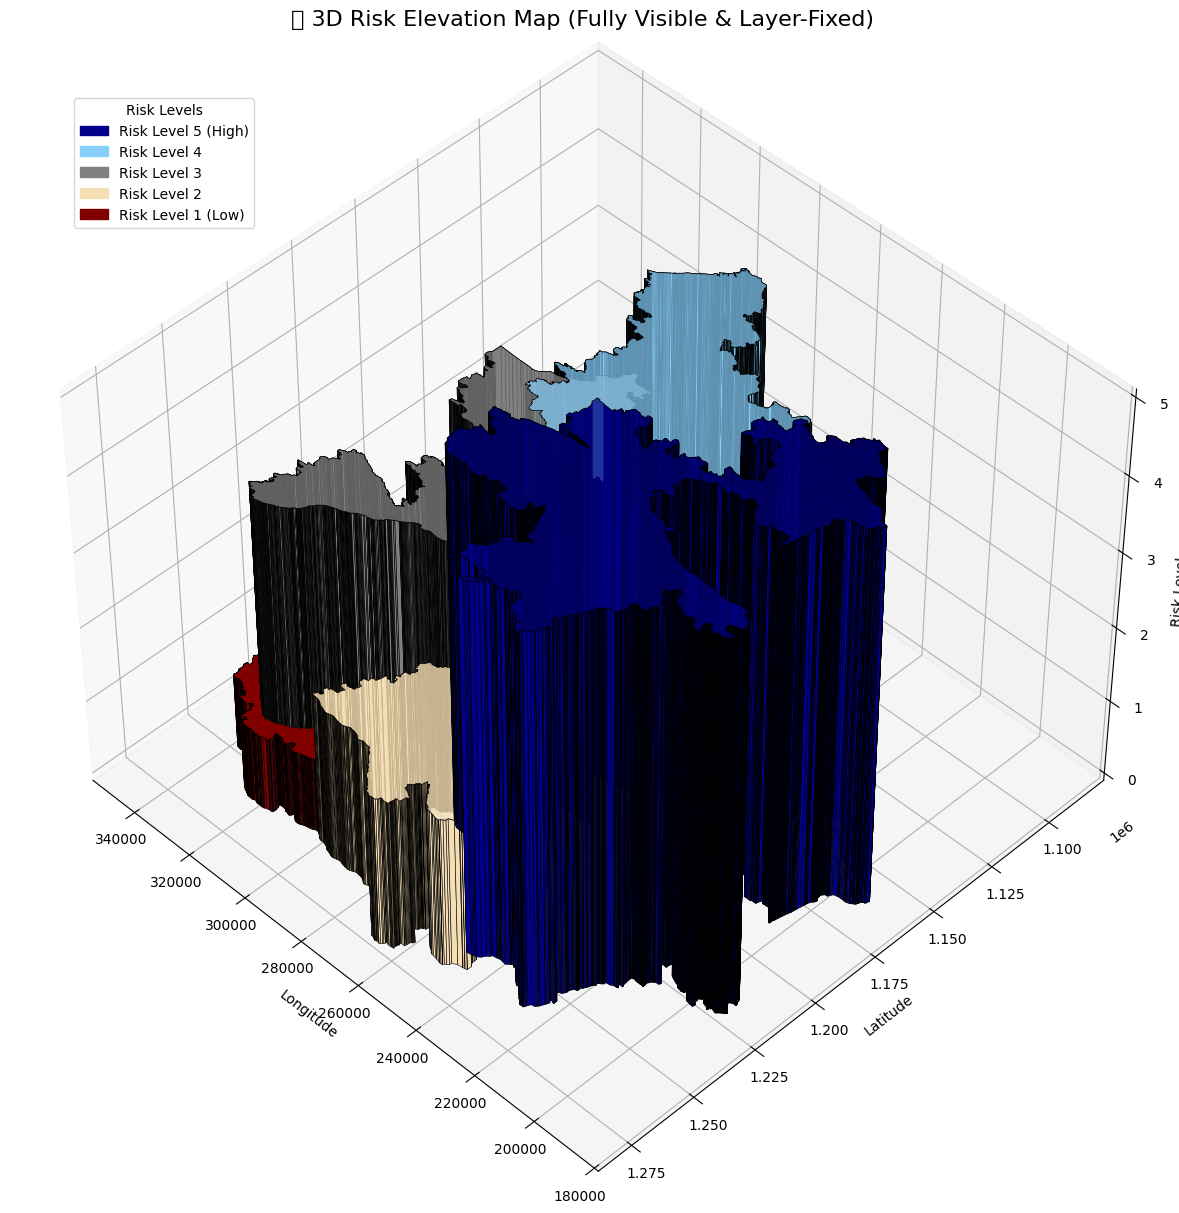

In [ ]:
# 🎨 Risk color mapping
colors = {
    5: 'darkblue',
    4: 'lightskyblue',
    3: 'gray',
    2: 'wheat',
    1: 'maroon'
}

# 🧊 Set alpha (transparency) for each risk level
alphas = {
    5: 0.65,
    4: 0.70,
    3: 0.75,
    2: 0.80,
    1: 1.00  # Fully visible for lowest risk
}

# 📊 Sort by Risk_Level: draw lower first
merged = merged.sort_values(by="Risk_Level", ascending=True)

# 📐 Start Plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level']) if pd.notna(row['Risk_Level']) else 1
    color = colors.get(risk_level, 'gray')
    alpha = alphas.get(risk_level, 0.7)
    height = risk_level
    z_offset = 0.05 if risk_level == 1 else 0  # Slight lift for maroon

    # Geometry handling
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)
    else:
        continue

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height + z_offset] * len(xs)))]
        base = [list(zip(xs, ys, [0 + z_offset] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(
            top, facecolors=color, edgecolor='black', alpha=alpha, linewidths=0.5))

        # Sides
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0 + z_offset, 0 + z_offset, height + z_offset, height + z_offset]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(
                verts, facecolors=color, edgecolor='black', linewidths=0.4, alpha=1.0))

# 🧭 View angle
ax.view_init(elev=45, azim=135)

# 🎯 Titles & labels
ax.set_title("🧱 3D Risk Elevation Map (Fully Visible & Layer-Fixed)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level")

# 🖌️ Legend
legend_patches = [
    mpatches.Patch(color='darkblue', label='Risk Level 5 (High)'),
    mpatches.Patch(color='lightskyblue', label='Risk Level 4'),
    mpatches.Patch(color='gray', label='Risk Level 3'),
    mpatches.Patch(color='wheat', label='Risk Level 2'),
    mpatches.Patch(color='maroon', label='Risk Level 1 (Low)')
]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')

plt.tight_layout()
plt.show()

<ipython-input-96-8173a1513524>:65: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


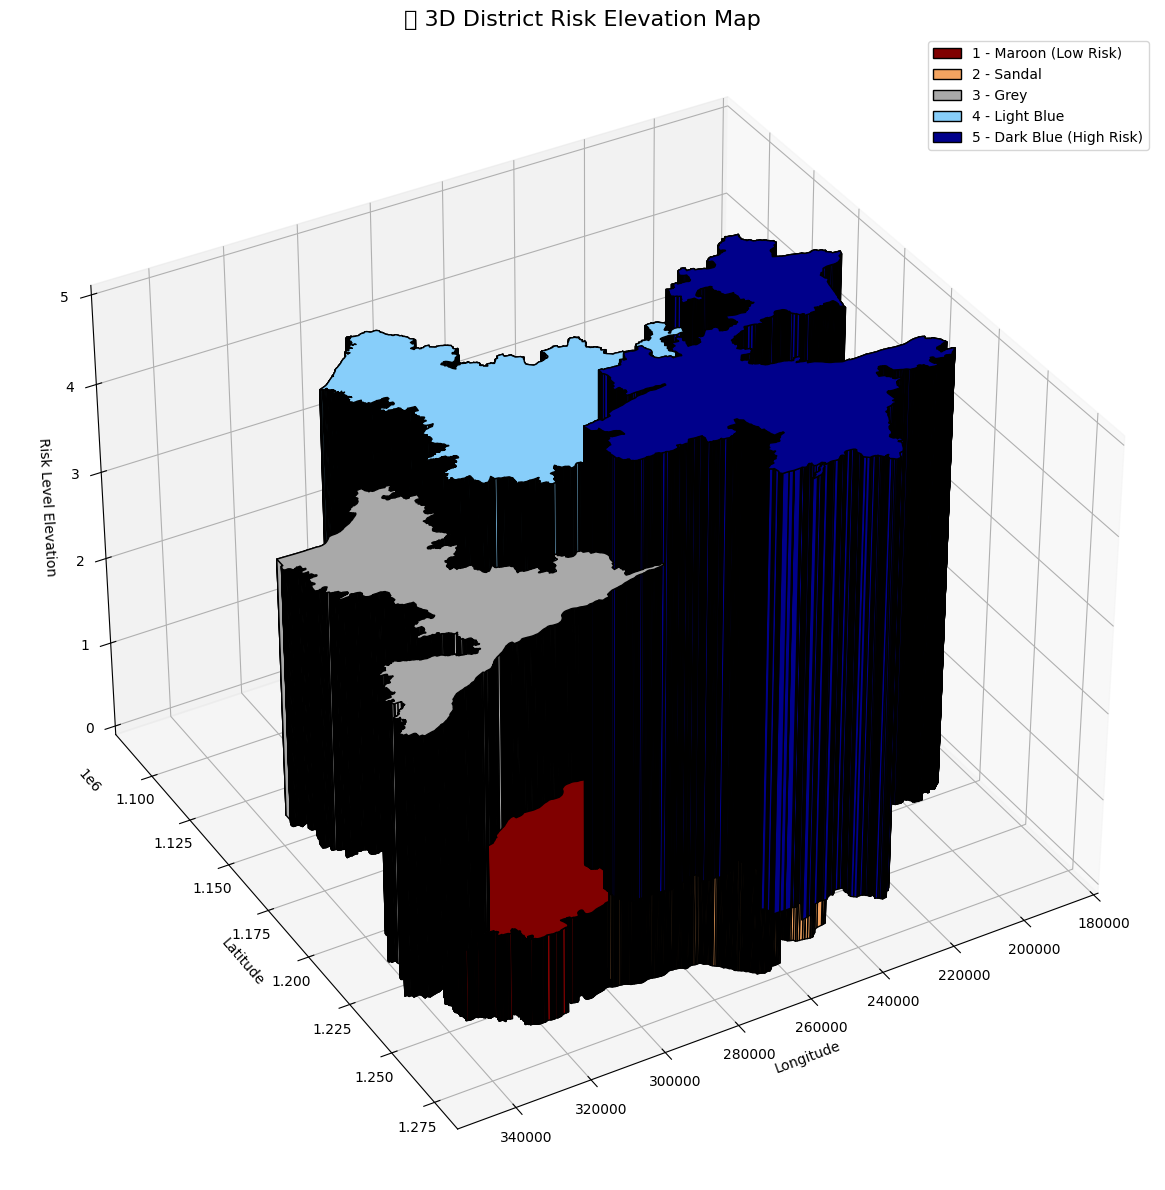

In [ ]:
# 🎨 Define Custom Risk Colors
colors = {
    1: '#800000',   # Maroon (lowest risk)
    2: '#F4A460',   # Sandal
    3: '#A9A9A9',   # Grey
    4: '#87CEFA',   # Light Blue
    5: '#00008B'    # Dark Blue (highest risk)
}

# 📊 Sort by Risk_Level for better rendering (low risk drawn last, appears on top)
merged = merged.sort_values(by='Risk_Level', ascending=False)

# 🧱 Plot 3D District Risk Map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level

    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # 🧱 Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))

        # 🧱 Walls
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

# 🔭 Adjust view for better visibility of all districts
ax.view_init(elev=35, azim=60)

# 🏷️ Labels
ax.set_title("🧱 3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level Elevation")

# 🗂️ Add Custom Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#800000', edgecolor='black', label='1 - Maroon (Low Risk)'),
    Patch(facecolor='#F4A460', edgecolor='black', label='2 - Sandal'),
    Patch(facecolor='#A9A9A9', edgecolor='black', label='3 - Grey'),
    Patch(facecolor='#87CEFA', edgecolor='black', label='4 - Light Blue'),
    Patch(facecolor='#00008B', edgecolor='black', label='5 - Dark Blue (High Risk)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

<ipython-input-97-240ae67e67c2>:70: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


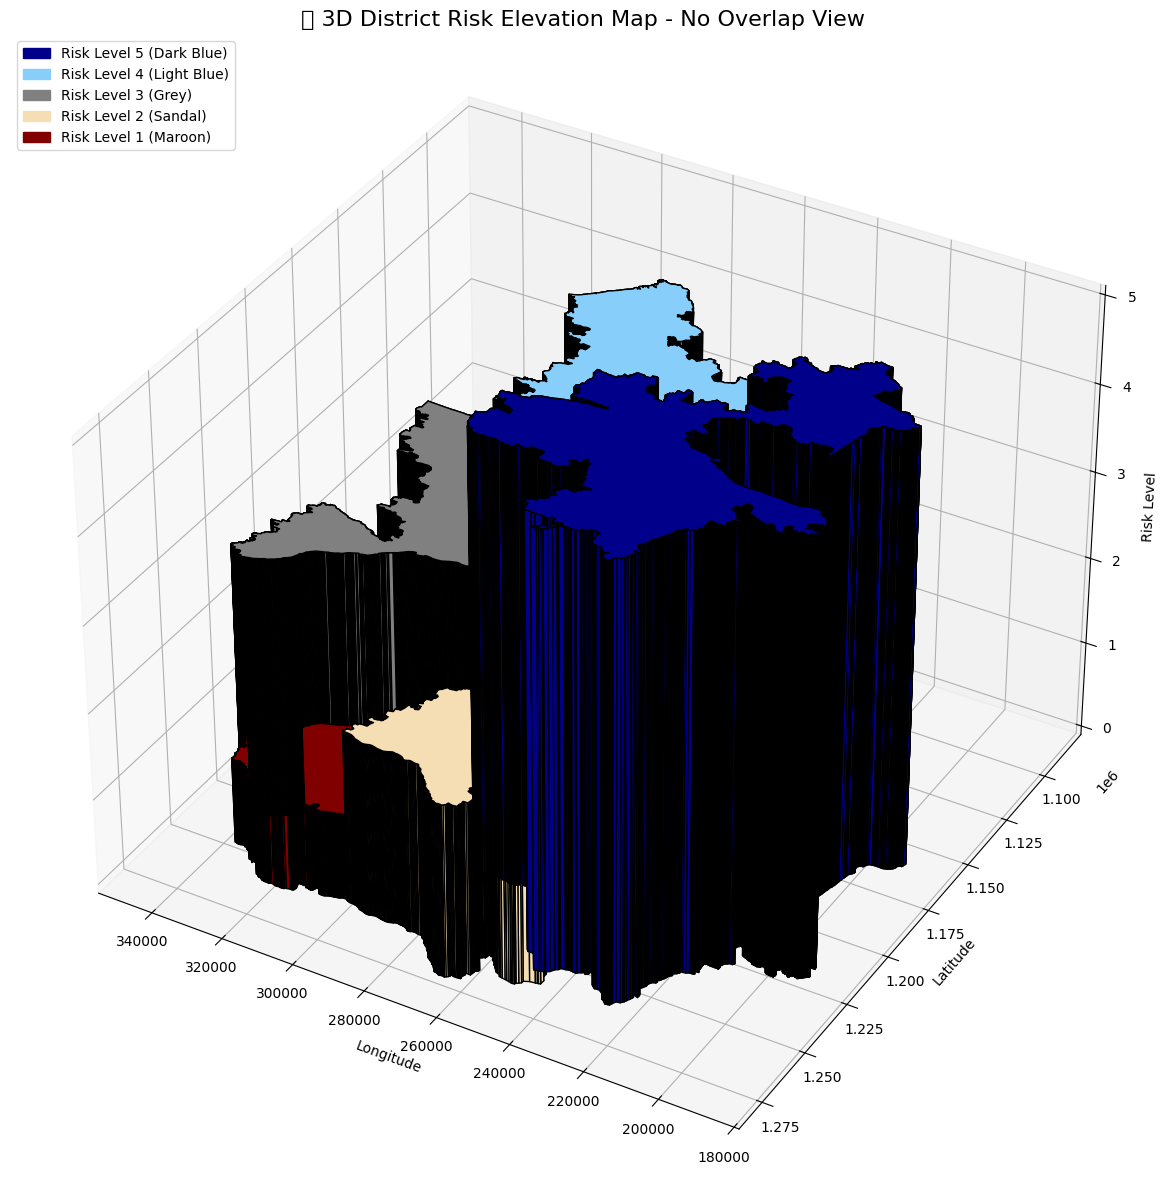

In [ ]:
colors = {
    5: 'darkblue',
    4: 'lightskyblue',
    3: 'grey',
    2: 'wheat',
    1: 'maroon'
}

# Define horizontal spacing to avoid overlap
district_spacing = 0.2
offset_x = 0

# Create plot
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Track colors for legend
legend_elements = []

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level'])
    color = colors.get(risk_level, 'gray')
    height = risk_level

    polygons = []
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        xs = [x + offset_x for x in xs]  # Add spacing for each district

        # Top surface
        top = [list(zip(xs, ys, [height] * len(xs)))]
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black'))

        # Walls
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black'))

    offset_x += district_spacing  # Move next district forward

# Set labels and view
ax.set_title("🧱 3D District Risk Elevation Map - No Overlap View", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level")

# Set camera angle to show all districts clearly
ax.view_init(elev=35, azim=120)

# Custom Legend
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='darkblue', label='Risk Level 5 (Dark Blue)'),
    mpatches.Patch(color='lightskyblue', label='Risk Level 4 (Light Blue)'),
    mpatches.Patch(color='grey', label='Risk Level 3 (Grey)'),
    mpatches.Patch(color='wheat', label='Risk Level 2 (Sandal)'),
    mpatches.Patch(color='maroon', label='Risk Level 1 (Maroon)')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# 🎨 Corrected color mapping based on your request
colors = {
    5: '#FF0000',       # Highest risk
    4: '#FFA500',
    3: '#808080',
    2: '#87CEEB',
    1: '#00008B'          # Lowest risk
}

# 🧱 Plot 3D elevation map
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for _, row in merged.iterrows():
    geom = row['geometry']
    risk_level = int(row['Risk_Level']) if pd.notna(row['Risk_Level']) else 1
    color = colors.get(risk_level, 'gray')
    height = risk_level

    # Handle geometries
    if isinstance(geom, Polygon):
        polygons = [geom]
    elif isinstance(geom, MultiPolygon):
        polygons = list(geom.geoms)
    else:
        continue

    for poly in polygons:
        xs, ys = poly.exterior.coords.xy
        top = [list(zip(xs, ys, [height] * len(xs)))]
        base = [list(zip(xs, ys, [0] * len(xs)))]

        # Top surface
        ax.add_collection3d(Poly3DCollection(top, facecolors=color, edgecolor='black', linewidths=0.3, alpha=1.0))
        # Vertical sides
        for i in range(len(xs) - 1):
            x = [xs[i], xs[i+1], xs[i+1], xs[i]]
            y = [ys[i], ys[i+1], ys[i+1], ys[i]]
            z = [0, 0, height, height]
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, edgecolor='black', linewidths=0.2))

# 🧭 Axis & view settings
ax.set_title("🧱 3D District Risk Elevation Map", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Risk Level")

# 🔭 Adjust view angle (slightly top, focusing all districts)
ax.view_init(elev=35, azim=120)

# 🖼️ Add custom legend
legend_patches = [
    mpatches.Patch(color='#FF0000', label='Risk Level 5 (Highest)'),
    mpatches.Patch(color='#FFA500', label='Risk Level 4'),
    mpatches.Patch(color='#808080', label='Risk Level 3'),
    mpatches.Patch(color='#87CEEB', label='Risk Level 2'),
    mpatches.Patch(color='#00008B', label='Risk Level 1 (Lowest)')
]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.05, 0.95), title='Risk Levels')

plt.tight_layout()
plt.show()